# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1500)
        y_train_pred = svm.predict(X_train_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
    
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.087143 val accuracy: 0.073000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.129612 val accuracy: 0.154000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.411367 val accuracy: 0.409000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.139449 val accuracy: 0.165000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.413143 val accuracy: 0.413000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.414918 val accuracy: 0.425000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.416776 val accuracy: 0.418000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.410143 val accuracy: 0.399000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.313531 val accuracy: 0.313000
best validation accuracy achieved during cross-validation: 0.425000


In [22]:


import numpy as np

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None
number_of_steps_in_dim = 10
learning_rate_values = np.geomspace(learning_rates[0],learning_rates[2], num=number_of_steps_in_dim)
regularization_strength_values = np.linspace(regularization_strengths[0],regularization_strengths[2], num=number_of_steps_in_dim)

for lr_i in learning_rate_values:
    for lambda_i in regularization_strength_values:
        
        print('Training SVM with lr={}, lamda={}'.format(lr_i, lambda_i))
        classifier_ij = LinearSVM()
        classifier_ij.train(X_train_feats, y_train, learning_rate=lr_i, reg=lambda_i,
                      num_iters=1500, verbose=True)
        
        y_train_pred = classifier_ij.predict(X_train_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = classifier_ij.predict(X_val_feats)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr_i, lambda_i)] = (train_accuracy, val_accuracy)
        print('---------------------------------------------')
        print('training accuracy: %f, val accuracy: %f' % (train_accuracy, val_accuracy))
        if best_val < val_accuracy:
            best_val = val_accuracy
            best_svm = classifier_ij
            print('found better model with val accuracy: {}'.format(val_accuracy))
        print('-------------------------------------------------------------------------------------')
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Training SVM with lr=1e-09, lamda=50000.0
iteration 0 / 1500: loss 85.981665
iteration 100 / 1500: loss 84.447133
iteration 200 / 1500: loss 82.965327
iteration 300 / 1500: loss 81.490059
iteration 400 / 1500: loss 80.045374
iteration 500 / 1500: loss 78.645984
iteration 600 / 1500: loss 77.279002
iteration 700 / 1500: loss 75.907019
iteration 800 / 1500: loss 74.594884
iteration 900 / 1500: loss 73.303524
iteration 1000 / 1500: loss 72.025104
iteration 1100 / 1500: loss 70.762158
iteration 1200 / 1500: loss 69.557133
iteration 1300 / 1500: loss 68.349743
iteration 1400 / 1500: loss 67.169789
---------------------------------------------
training accuracy: 0.084816, val accuracy: 0.091000
found better model with val accuracy: 0.091
-------------------------------------------------------------------------------------
Training SVM with lr=1e-09, lamda=600000.0
iteration 0 / 1500: loss 956.455155
iteration 100 / 1500: loss 754.191480
iteration 200 / 1500: loss 595.099787
iteration 300 / 1

-------------------------------------------------------------------------------------
Training SVM with lr=1.6681005372000556e-09, lamda=50000.0
iteration 0 / 1500: loss 85.355780
iteration 100 / 1500: loss 82.847834
iteration 200 / 1500: loss 80.437823
iteration 300 / 1500: loss 78.089408
iteration 400 / 1500: loss 75.821748
iteration 500 / 1500: loss 73.618747
iteration 600 / 1500: loss 71.501235
iteration 700 / 1500: loss 69.454042
iteration 800 / 1500: loss 67.472466
iteration 900 / 1500: loss 65.554435
iteration 1000 / 1500: loss 63.707931
iteration 1100 / 1500: loss 61.889460
iteration 1200 / 1500: loss 60.174432
iteration 1300 / 1500: loss 58.484050
iteration 1400 / 1500: loss 56.865696
---------------------------------------------
training accuracy: 0.099878, val accuracy: 0.119000
-------------------------------------------------------------------------------------
Training SVM with lr=1.6681005372000556e-09, lamda=600000.0
iteration 0 / 1500: loss 910.716545
iteration 100 / 1

iteration 0 / 1500: loss 85.482080
iteration 100 / 1500: loss 81.329765
iteration 200 / 1500: loss 77.422795
iteration 300 / 1500: loss 73.725558
iteration 400 / 1500: loss 70.217616
iteration 500 / 1500: loss 66.890738
iteration 600 / 1500: loss 63.753594
iteration 700 / 1500: loss 60.801784
iteration 800 / 1500: loss 57.988281
iteration 900 / 1500: loss 55.344884
iteration 1000 / 1500: loss 52.839249
iteration 1100 / 1500: loss 50.460298
iteration 1200 / 1500: loss 48.214658
iteration 1300 / 1500: loss 46.091593
iteration 1400 / 1500: loss 44.086511
---------------------------------------------
training accuracy: 0.090694, val accuracy: 0.092000
-------------------------------------------------------------------------------------
Training SVM with lr=2.7825594022071257e-09, lamda=600000.0
iteration 0 / 1500: loss 963.796169
iteration 100 / 1500: loss 498.108235
iteration 200 / 1500: loss 259.542088
iteration 300 / 1500: loss 137.346508
iteration 400 / 1500: loss 74.745356
iteration 5

iteration 600 / 1500: loss 53.478847
iteration 700 / 1500: loss 49.528659
iteration 800 / 1500: loss 45.931673
iteration 900 / 1500: loss 42.658507
iteration 1000 / 1500: loss 39.683101
iteration 1100 / 1500: loss 36.954712
iteration 1200 / 1500: loss 34.479080
iteration 1300 / 1500: loss 32.219760
iteration 1400 / 1500: loss 30.153406
---------------------------------------------
training accuracy: 0.088816, val accuracy: 0.077000
-------------------------------------------------------------------------------------
Training SVM with lr=4.641588833612773e-09, lamda=600000.0
iteration 0 / 1500: loss 909.581411
iteration 100 / 1500: loss 303.701016
iteration 200 / 1500: loss 105.431224
iteration 300 / 1500: loss 40.554752
iteration 400 / 1500: loss 19.327063
iteration 500 / 1500: loss 12.378775
iteration 600 / 1500: loss 10.105953
iteration 700 / 1500: loss 9.361820
iteration 800 / 1500: loss 9.118305
iteration 900 / 1500: loss 9.038725
iteration 1000 / 1500: loss 9.012671
iteration 1100

iteration 1100 / 1500: loss 22.733512
iteration 1200 / 1500: loss 20.758611
iteration 1300 / 1500: loss 19.073779
iteration 1400 / 1500: loss 17.629462
---------------------------------------------
training accuracy: 0.085878, val accuracy: 0.075000
-------------------------------------------------------------------------------------
Training SVM with lr=7.742636826811278e-09, lamda=600000.0
iteration 0 / 1500: loss 925.695774
iteration 100 / 1500: loss 150.722133
iteration 200 / 1500: loss 30.909107
iteration 300 / 1500: loss 12.387474
iteration 400 / 1500: loss 9.523512
iteration 500 / 1500: loss 9.080796
iteration 600 / 1500: loss 9.012517
iteration 700 / 1500: loss 9.001913
iteration 800 / 1500: loss 9.000271
iteration 900 / 1500: loss 9.000011
iteration 1000 / 1500: loss 8.999978
iteration 1100 / 1500: loss 8.999975
iteration 1200 / 1500: loss 8.999974
iteration 1300 / 1500: loss 8.999970
iteration 1400 / 1500: loss 8.999964
---------------------------------------------
training a

-------------------------------------------------------------------------------------
Training SVM with lr=1.2915496650148827e-08, lamda=600000.0
iteration 0 / 1500: loss 902.643461
iteration 100 / 1500: loss 48.304311
iteration 200 / 1500: loss 10.728647
iteration 300 / 1500: loss 9.076190
iteration 400 / 1500: loss 9.003320
iteration 500 / 1500: loss 9.000116
iteration 600 / 1500: loss 8.999980
iteration 700 / 1500: loss 8.999973
iteration 800 / 1500: loss 8.999975
iteration 900 / 1500: loss 8.999972
iteration 1000 / 1500: loss 8.999973
iteration 1100 / 1500: loss 8.999975
iteration 1200 / 1500: loss 8.999970
iteration 1300 / 1500: loss 8.999972
iteration 1400 / 1500: loss 8.999963
---------------------------------------------
training accuracy: 0.413020, val accuracy: 0.408000
-------------------------------------------------------------------------------------
Training SVM with lr=1.2915496650148827e-08, lamda=1150000.0
iteration 0 / 1500: loss 1822.871147
iteration 100 / 1500: los

iteration 300 / 1500: loss 9.000109
iteration 400 / 1500: loss 8.999967
iteration 500 / 1500: loss 8.999971
iteration 600 / 1500: loss 8.999970
iteration 700 / 1500: loss 8.999979
iteration 800 / 1500: loss 8.999971
iteration 900 / 1500: loss 8.999978
iteration 1000 / 1500: loss 8.999971
iteration 1100 / 1500: loss 8.999973
iteration 1200 / 1500: loss 8.999966
iteration 1300 / 1500: loss 8.999979
iteration 1400 / 1500: loss 8.999971
---------------------------------------------
training accuracy: 0.416143, val accuracy: 0.430000
found better model with val accuracy: 0.43
-------------------------------------------------------------------------------------
Training SVM with lr=2.1544346900318822e-08, lamda=1150000.0
iteration 0 / 1500: loss 1772.426959
iteration 100 / 1500: loss 9.067967
iteration 200 / 1500: loss 8.999990
iteration 300 / 1500: loss 8.999986
iteration 400 / 1500: loss 8.999981
iteration 500 / 1500: loss 8.999984
iteration 600 / 1500: loss 8.999985
iteration 700 / 1500: 

iteration 900 / 1500: loss 8.999973
iteration 1000 / 1500: loss 8.999970
iteration 1100 / 1500: loss 8.999971
iteration 1200 / 1500: loss 8.999966
iteration 1300 / 1500: loss 8.999975
iteration 1400 / 1500: loss 8.999972
---------------------------------------------
training accuracy: 0.415306, val accuracy: 0.417000
-------------------------------------------------------------------------------------
Training SVM with lr=3.593813663804626e-08, lamda=1150000.0
iteration 0 / 1500: loss 1758.643150
iteration 100 / 1500: loss 9.000033
iteration 200 / 1500: loss 8.999985
iteration 300 / 1500: loss 8.999983
iteration 400 / 1500: loss 8.999987
iteration 500 / 1500: loss 8.999981
iteration 600 / 1500: loss 8.999985
iteration 700 / 1500: loss 8.999985
iteration 800 / 1500: loss 8.999985
iteration 900 / 1500: loss 8.999984
iteration 1000 / 1500: loss 8.999985
iteration 1100 / 1500: loss 8.999986
iteration 1200 / 1500: loss 8.999986
iteration 1300 / 1500: loss 8.999986
iteration 1400 / 1500: los

training accuracy: 0.407653, val accuracy: 0.421000
-------------------------------------------------------------------------------------
Training SVM with lr=5.99484250318941e-08, lamda=1150000.0
iteration 0 / 1500: loss 1779.598678
iteration 100 / 1500: loss 8.999987
iteration 200 / 1500: loss 8.999987
iteration 300 / 1500: loss 8.999987
iteration 400 / 1500: loss 8.999990
iteration 500 / 1500: loss 8.999987
iteration 600 / 1500: loss 8.999985
iteration 700 / 1500: loss 8.999979
iteration 800 / 1500: loss 8.999987
iteration 900 / 1500: loss 8.999985
iteration 1000 / 1500: loss 8.999986
iteration 1100 / 1500: loss 8.999985
iteration 1200 / 1500: loss 8.999989
iteration 1300 / 1500: loss 8.999985
iteration 1400 / 1500: loss 8.999984
---------------------------------------------
training accuracy: 0.400469, val accuracy: 0.394000
-------------------------------------------------------------------------------------
Training SVM with lr=5.99484250318941e-08, lamda=1700000.0
iteration 0 / 

iteration 400 / 1500: loss 8.999987
iteration 500 / 1500: loss 8.999982
iteration 600 / 1500: loss 8.999986
iteration 700 / 1500: loss 8.999985
iteration 800 / 1500: loss 8.999986
iteration 900 / 1500: loss 8.999985
iteration 1000 / 1500: loss 8.999983
iteration 1100 / 1500: loss 8.999992
iteration 1200 / 1500: loss 8.999985
iteration 1300 / 1500: loss 8.999987
iteration 1400 / 1500: loss 8.999989
---------------------------------------------
training accuracy: 0.405653, val accuracy: 0.413000
-------------------------------------------------------------------------------------
Training SVM with lr=1e-07, lamda=1700000.0
iteration 0 / 1500: loss 2583.269337
iteration 100 / 1500: loss 8.999991
iteration 200 / 1500: loss 8.999992
iteration 300 / 1500: loss 8.999991
iteration 400 / 1500: loss 8.999992
iteration 500 / 1500: loss 8.999991
iteration 600 / 1500: loss 8.999992
iteration 700 / 1500: loss 8.999995
iteration 800 / 1500: loss 8.999992
iteration 900 / 1500: loss 8.999993
iteration 

lr 2.782559e-09 reg 3.900000e+06 train accuracy: 0.410592 val accuracy: 0.422000
lr 2.782559e-09 reg 4.450000e+06 train accuracy: 0.413449 val accuracy: 0.413000
lr 2.782559e-09 reg 5.000000e+06 train accuracy: 0.411082 val accuracy: 0.405000
lr 4.641589e-09 reg 5.000000e+04 train accuracy: 0.088816 val accuracy: 0.077000
lr 4.641589e-09 reg 6.000000e+05 train accuracy: 0.342143 val accuracy: 0.337000
lr 4.641589e-09 reg 1.150000e+06 train accuracy: 0.415020 val accuracy: 0.428000
lr 4.641589e-09 reg 1.700000e+06 train accuracy: 0.414041 val accuracy: 0.413000
lr 4.641589e-09 reg 2.250000e+06 train accuracy: 0.414959 val accuracy: 0.417000
lr 4.641589e-09 reg 2.800000e+06 train accuracy: 0.414571 val accuracy: 0.421000
lr 4.641589e-09 reg 3.350000e+06 train accuracy: 0.406531 val accuracy: 0.415000
lr 4.641589e-09 reg 3.900000e+06 train accuracy: 0.410163 val accuracy: 0.405000
lr 4.641589e-09 reg 4.450000e+06 train accuracy: 0.408633 val accuracy: 0.412000
lr 4.641589e-09 reg 5.000000

In [23]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.414


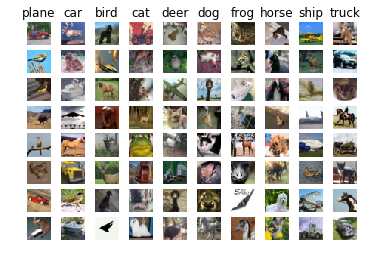

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$  Since we have only used those features like the color histogram features and the HOG features that made some misclassification results because they aren't enough to distinguish between the  different classes carefully.




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [13]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)
print(X_test_feats.shape)

(49000, 154)
(49000, 153)
(1000, 153)


In [24]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

def get_random_numbers_within_range(lr_min, lr_max, reg_min, reg_max, h_min, h_max):
    #lr = 10**np.random.uniform(low=np.log10(lr_min), high=np.log10(lr_max))
    #reg = 10**np.random.uniform(low=np.log10(reg_min), high=np.log10(reg_max))
    lr = 10**np.random.uniform(lr_min, lr_max)
    reg = 10**np.random.uniform(reg_min, reg_max)
    hidden = np.random.randint(h_min, h_max)
    return lr, reg, hidden

#random search for parameters 
for i in range(50):
    lr, reg, hidden_dim = get_random_numbers_within_range(-1, 0, -7, -4, 50, 500)
    
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=3000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=False)
                    
    train_accuracy = (net.predict(X_train_feats) == y_train).mean()
    val_accuracy = (net.predict(X_val_feats) == y_val).mean()
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_net = net
    
    print('lr: {}, reg: {}, hid: {},  train accuracy: {}, val accuracy:{}' .format(lr, reg, hidden_dim, train_accuracy, val_accuracy))
print('best validation accuracy achieved: {}' .format(best_val))
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


lr: 0.4373588481460652, reg: 1.6690217090863353e-07, hid: 480,  train accuracy: 0.7637755102040816, val accuracy:0.586
lr: 0.8498962838916548, reg: 1.4652943819647382e-06, hid: 251,  train accuracy: 0.7736530612244898, val accuracy:0.547
lr: 0.2666831284282768, reg: 1.0509478192583342e-07, hid: 132,  train accuracy: 0.6653469387755102, val accuracy:0.571
lr: 0.3521446737081918, reg: 7.679916204548515e-05, hid: 435,  train accuracy: 0.7374285714285714, val accuracy:0.606
lr: 0.8162523736387659, reg: 1.7600946582090052e-07, hid: 65,  train accuracy: 0.644061224489796, val accuracy:0.589
lr: 0.14623049977063868, reg: 9.408656410300848e-07, hid: 176,  train accuracy: 0.6210408163265306, val accuracy:0.582
lr: 0.162996876985141, reg: 7.740819053297064e-05, hid: 62,  train accuracy: 0.6039591836734693, val accuracy:0.576
lr: 0.227652697364375, reg: 2.2925445601711389e-07, hid: 139,  train accuracy: 0.6510816326530612, val accuracy:0.575
lr: 0.9539206268821863, reg: 1.4569555363646824e-07, hi

In [25]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.572
